In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm
from sentencepiece import SentencePieceProcessor
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import json
import random
import copy
from collections import OrderedDict
from sklearn.model_selection import train_test_split

In [3]:
spm=SentencePieceProcessor(model_file="sql2.model")

In [4]:
MASTER_CONFIG = {
    "vocab_size": spm.vocab_size(), #토크나이져 크기
    'd_model': 128,
    'batch_size':256,
    'epochs':10,
    'context_window':64,
    'log_interval': 10,
    'n_heads': 8, #헤드
    'n_layers': 4,
}

In [5]:
MASTER_CONFIG.update({
    'd_model': 128,
    'batch_size':1024,
    'epochs':100,
    'context_window':8,
    'log_interval': 10,
    'n_heads': 8,
    'n_layers': 4,
    's_id':0,
    'msize':4,
})

In [6]:
print(MASTER_CONFIG)

{'vocab_size': 2007, 'd_model': 128, 'batch_size': 1024, 'epochs': 100, 'context_window': 8, 'log_interval': 10, 'n_heads': 8, 'n_layers': 4, 's_id': 0, 'msize': 4}


In [20]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches_cuda(split, config['batch_size'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [37]:
n_dec=MASTER_CONFIG['context_window']
def makebatch(datafile, trainfile, testfile, valfile):
    qs = []
    ans = []
    lines = open(datafile, 'r').readlines()
    train_data, test_data = train_test_split(lines, test_size=0.3, random_state=42)
    test_data, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
    def write_to_file(file, data):
        id=0
        with open(file, "w") as f:
            f.write("[")
            for i, line in enumerate(data):
                ans = spm.encode_as_ids(line)
                l = len(ans)
                if (l > n_dec - 2):
                    ans = ans[:n_dec - 2]
                qs = copy.deepcopy(ans)
                l = len(qs)
                qs.insert(0,2)
                ans.append(3)
                ran = random.randrange(1, l + 1)
                qs[ran] = 6 # vocab 상 2=bos 3= eos 6=mask
                datablock = {"id": id, "anser": ans, "question": qs}
                f.write(json.dumps(datablock))
                if i == len(data) - 1:
                  f.write("\n")
                else:
                  f.write(",\n")
                id += 1
            f.write("]")
    write_to_file(trainfile, train_data)
    write_to_file(testfile, test_data)
    write_to_file(valfile, val_data)

In [95]:
makebatch("Kaggle_SQL_Data.txt","train.json","test.json","val.json")

In [47]:
n_dec=MASTER_CONFIG['context_window']
def makebatch_notmasked(datafile, trainfile, testfile, valfile):
    qs = []
    ans = []
    lines = open(datafile, 'r').readlines()
    train_data, test_data = train_test_split(lines, test_size=0.3, random_state=42)
    test_data, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
    def write_to_file(file, data):
        id=0
        with open(file, "w") as f:
            f.write("[")
            for i, line in enumerate(data):
                ans = spm.encode_as_ids(line)
                l = len(ans)
                if (l > n_dec - 2):
                    ans = ans[:n_dec - 2]
                qs = copy.deepcopy(ans)
                l = len(qs)
                qs.insert(0,2)
                ans.append(3)
                #ran = random.randrange(1, l + 1)
                #qs[ran] = 6 # vocab 상 2=bos 3= eos 6=mask
                datablock = {"id": id, "anser": ans, "question": qs}
                f.write(json.dumps(datablock))
                if i == len(data) - 1:
                  f.write("\n")
                else:
                  f.write(",\n")
                id += 1
            f.write("]")
    write_to_file(trainfile, train_data)
    write_to_file(testfile, test_data)
    write_to_file(valfile, val_data)

In [63]:
makebatch_notmasked("Kaggle_SQL_Data.txt","train.json","test.json","val.json")

In [39]:
def searchbyid(id,id_dict):
  if id in id_dict:
    result = id_dict[id]
    ans=result.get('anser')
    q=result.get('question')
    ans=torch.tensor(ans,dtype=torch.long).to("cuda")
    q=torch.tensor(q,dtype=torch.long).to("cuda")
    return ans,q

In [78]:
def get_batches_cuda(split, batch_size, config=MASTER_CONFIG):
  if split == 'val':
    val=open("val.json",'r')
    batch_data = val
  elif split == 'test':
    test=open("test.json",'r')
    batch_data = test
  else:
    train=open("train.json",'r')
    batch_data = train
  d=json.load(batch_data)
  id_dict = {item["id"]: item for item in d}
  max_id = max(id_dict.keys()) if id_dict else None
  rand= random.randint(0, max_id-batch_size)
  x=[]
  y=[]
  for _ in range(rand,rand+batch_size):
    ans,q=searchbyid(_,id_dict)
    size_of_ans=ans.size()[0]
    if size_of_ans>MASTER_CONFIG['context_window']:
      ans=ans[:MASTER_CONFIG['context_window']]
      q=q[:MASTER_CONFIG['context_window']]
    ans=ans.to(device)
    q=q.to(device)
    x.append(ans)
    y.append(q)
  size_of_x = x[0].size()[0]
  size_of_y = y[0].size()[0]
  x[0]=F.pad(x[0], (0,MASTER_CONFIG['context_window']-int(size_of_x)), mode='constant', value=0)
  y[0]=F.pad(y[0], (0,MASTER_CONFIG['context_window']-int(size_of_y)), mode='constant', value=0)
  x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=0)
  y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)
  return y,x
def train_cuda(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    model=model.to("cuda")
    losses = []
    start_time = time.time()
    for epoch in tqdm(range(config['epochs'])):
        optimizer.zero_grad()
        xs, ys = get_batches_cuda('train', MASTER_CONFIG['batch_size'], config=MASTER_CONFIG)
        #xs, ys = xs.to(device), ys.to(device)  # 입력 데이터를 GPU로 이동
        logits, loss = model(xs, targets=ys.long())
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

In [41]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        ff_rms = ff_rms.to("cuda")
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        #raw.to("cuda")
        return self.scale[:x.shape[1], :].unsqueeze(0).to("cuda") * raw
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False).to("cuda")
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)
        if device=="cuda":
          q=q.to(device)
          k=k.to(device)
          v=v.to(device)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = MASTER_CONFIG
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model']).to("cuda")
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        ).to("cuda")

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

In [83]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
llama2 = Llama(MASTER_CONFIG)

model params: 2865244


In [85]:
optimizer = torch.optim.Adam(llama2.parameters())

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]

validation loss:  2.257420468330383


<Axes: >

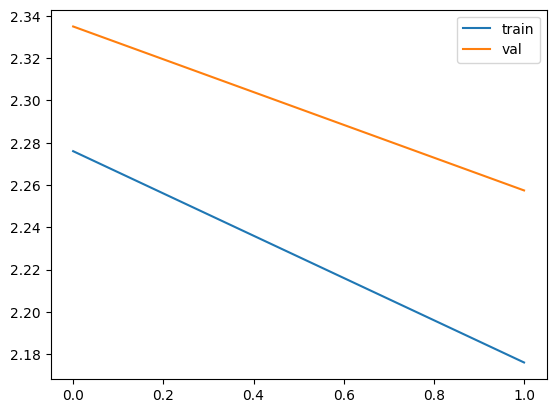

In [88]:
train_cuda(llama2, optimizer, config=MASTER_CONFIG)

100%|██████████| 100/100 [01:11<00:00,  1.40it/s]

validation loss:  1.8989244461059571


<Axes: >

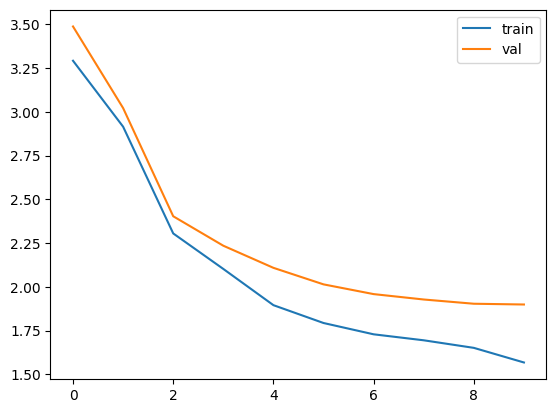

In [97]:
train_cuda(llama2, optimizer, config=MASTER_CONFIG)

100%|██████████| 300/300 [03:37<00:00,  1.38it/s]

validation loss:  1.7145881056785583


<Axes: >

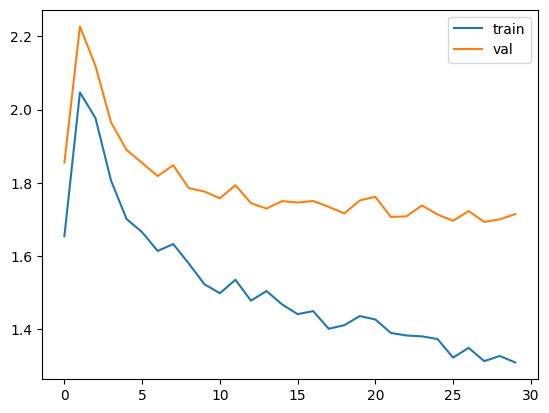

In [92]:
train_cuda(llama2, optimizer, config=MASTER_CONFIG)

In [96]:
MASTER_CONFIG.update({
    'd_model': 128,
    'batch_size':1024,
    'epochs':100,
    'context_window':8,
    'log_interval': 10,
    'n_heads': 8,
    'n_layers': 4,
    's_id':0,
    'msize':4,
})

In [79]:
xs,ys=get_batches_cuda('train', MASTER_CONFIG['batch_size'], config=MASTER_CONFIG)

In [81]:
print(xs[1023])
print(ys[1023])

tensor([   2,  329, 1954, 1928,  138,  495, 1938,    0], device='cuda:0')
tensor([ 329, 1954, 1928,  138,  495, 1938,    3,    0], device='cuda:0')


In [94]:
model_weights = llama2.state_dict()
torch.save(model_weights, 'lm5.pth')